# Draw a polygon

The Notebook shows how to:

1. Define an area of interest by drawing a polygon on a Leaflet map
2. Perform a spatial query over the dataset with a UDF
3. View the output on a map

It shows examples for using both `ipyleaflet` and `geemap`.

Let's begin!

In [ ]:
# !pip install fused ipyleaflet geopandas odc-stac planetary-computer -q

In [1]:
# If on colab, Enable the ipyleaflet widget (might require restarting the kernel)

# !pip install ipywidgets==7.7.1 -q
# from google.colab import output
# output.enable_custom_widget_manager()

## 1. Draw polygon with `ipyleaflet`
Draw a polygon around the AOI and on the map and wait for building polygons to load.

Note: the workflow is designed to work with a single polygon.

In [4]:
import geopandas as gpd
from ipyleaflet import DrawControl, Map, basemap_to_tiles, basemaps
from shapely.geometry import shape

# Create a map centered at the given location
MAP_LOCATION = (37.7749, -122.4194)


m = Map(
    layers=(basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),),
    center=MAP_LOCATION,
    zoom=14,
)


draw_control = DrawControl()
draw_control.polygon = {
    "shapeOptions": {"color": "red", "fillOpacity": 0.0},
    "drawError": {"color": "#dd253b", "message": "Oups!"},
    "allowIntersection": False,
}

draw_control.rectangle = {"shapeOptions": {"color": "red", "fillOpacity": 0.0}}

m.add(draw_control)

Map(center=[37.7749, -122.4194], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

## 2. Convert polygon to GeoDataFrame

In [6]:
gdf = gpd.GeoDataFrame(
    index=[0], crs="epsg:4326", geometry=[shape(draw_control.last_draw.get("geometry"))]
)
gdf

,geometry
0,"POLYGON ((-122.40795 37.78150, -122.41293 37.7..."


## 3. Run UDFs with bbox input

### a. Spatial query of Sentinel on Planetary Computer

This UDF takes the input `bbox` bounds to perform a spatial query of the Sentinel dataset.

In [7]:
import fused


@fused.udf
def udf(bbox, time_of_interest="2023-11-01/2023-12-30"):

    import odc.stac
    import planetary_computer
    import pystac_client

    utils = fused.load(
        "https://github.com/fusedio/udfs/tree/f928ee1/public/common/"
    ).utils

    red_band = "B04"
    nir_band = "B08"
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    items = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox.total_bounds,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": 10}},
    ).item_collection()

    print(f"Returned {len(items)} Items")
    resolution = int(5 * 2 ** (15 - bbox.z[0]))
    print(f"{resolution=}")
    ds = odc.stac.load(
        items,
        crs="EPSG:3857",
        bands=[nir_band, red_band],
        resolution=resolution,
        bbox=bbox.total_bounds,
    ).astype(float)
    ndvi = (ds[nir_band] - ds[red_band]) / (ds[nir_band] + ds[red_band])
    print(ndvi.shape)
    arr = ndvi.max(dim="time")
    return utils.arr_to_plasma(arr.values, min_max=(0, 0.8), reverse=False)


arr = fused.run(udf=udf, bbox=gdf, engine="local")

Returned 2 Items
resolution=20
(2, 21, 49)


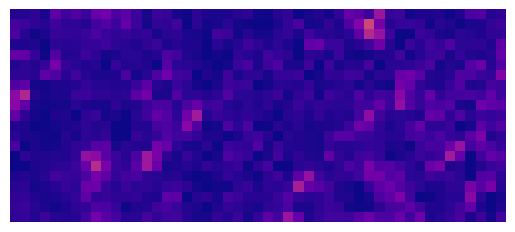

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose the axes to match image format
image_array = np.transpose(arr, (1, 2, 0))

# Display the image
plt.imshow(image_array)
plt.axis("off")  # Optional: turn off axis
plt.show()

### b. Spatial query of Overture Buildings

This User Defined Function (UDF) queries a geo partitioned version of the Overture Buildings Dataset (hosted on an S3 bucket) that corresponds to the area of an input GeoDataFrame. It returns a GeoDataFrame containing the subsampled data, which gets cached to the local environment for added speed.

In [ ]:
import fused
import geopandas as gpd

udf = fused.load(
    "https://github.com/fusedio/udfs/tree/main/public/Overture_Maps_Example"
)
gdf_output = fused.run(udf, bbox=gdf, engine="realtime")
output = gpd.GeoDataFrame(gdf_output, geometry="geometry", crs="epsg:4326")
output.plot()